In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab

In [6]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load Data

In [68]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv')
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv')
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientSCOData.csv')

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\HealthyData.csv

Parsing completed. Parsed 100 lines in 0.10027 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above 

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\HealthyData.csv

Parsing completed. Parsed 8375 lines in 0.134362 secs.

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\PatientCBRData.csv

Parsing completed. Parsed 100 lines in 0.220594 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above 

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\PatientCBRData.csv

Parsing completed. Parsed 22354 lines in 0.314847 secs.

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\PatientSCOData.csv

Parsing completed. Parsed 100 lines in 0.205554 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,long,long,long,long,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above 

Finished parsing file C:\Users\llonini\Projects\Datasets\Cbrace\PatientSCOData.csv

Parsing completed. Parsed 18762 lines in 0.301813 secs.

In [40]:
CBRData.head(4)

Columns:
	SubjID	int
	Session	int
	Features_  1	float
	Features_  2	float
	Features_  3	float
	Features_  4	int
	Features_  5	int
	Features_  6	int
	Features_  7	int
	Features_  8	float
	Features_  9	float
	Features_ 10	float
	Features_ 11	float
	Features_ 12	float
	Features_ 13	float
	Features_ 14	float
	Features_ 15	float
	Features_ 16	float
	Features_ 17	float
	Features_ 18	int
	Features_ 19	int
	Features_ 20	int
	Features_ 21	int
	Features_ 22	float
	Features_ 23	float
	Features_ 24	float
	Features_ 25	float
	Features_ 26	float
	Features_ 27	float
	Features_ 28	float
	Features_ 29	float
	Features_ 30	float
	Features_ 31	float
	Features_ 32	int
	Features_ 33	int
	Features_ 34	int
	Features_ 35	int
	Features_ 36	float
	Features_ 37	float
	Features_ 38	float
	Features_ 39	float
	Features_ 40	float
	Features_ 41	float
	Features_ 42	float
	Features_ 43	float
	Features_ 44	float
	Features_ 45	float
	Features_ 46	float
	Features_ 47	float
	Features_ 48	float
	Features_ 49	float
	Features_ 50	float
	Features_ 51	float
	Features_ 52	float
	Features_ 53	float
	Features_ 54	float
	Features_ 55	float
	Features_ 56	float
	Features_ 57	float
	Features_ 58	float
	Features_ 59	float
	Features_ 60	float
	Features_ 61	float
	Features_ 62	float
	Features_ 63	float
	Features_ 64	float
	Features_ 65	float
	Features_ 66	float
	Features_ 67	float
	Features_ 68	float
	Features_ 69	float
	Features_ 70	float
	Features_ 71	float
	Features_ 72	float
	Features_ 73	float
	Features_ 74	float
	Features_ 75	float
	Features_ 76	float
	Features_ 77	float
	Features_ 78	float
	Features_ 79	float
	Features_ 80	float
	Features_ 81	float
	Features_ 82	float
	Features_ 83	float
	Features_ 84	float
	Features_ 85	float
	Features_ 86	float
	Features_ 87	float
	Features_ 88	float
	Features_ 89	float
	Features_ 90	float
	Features_ 91	float
	Features_ 92	float
	Features_ 93	float
	Features_ 94	float
	Features_ 95	float
	Features_ 96	float
	Features_ 97	float
	Features_ 98	float
	Features_ 99	float
	Features_100	float
	Features_101	float
	Features_102	float
	Features_103	float
	Features_104	float
	Features_105	float
	Features_106	float
	Features_107	float
	Features_108	float
	Features_109	float
	Features_110	float
	Features_111	float
	Features_112	float
	Features_113	float
	Features_114	float
	Features_115	float
	Features_116	float
	Features_117	float
	Features_118	float
	Features_119	float
	Features_120	float
	Features_121	float
	Features_122	float
	Features_123	float
	Features_124	float
	Features_125	float
	Features_126	float
	Features_127	float
	Features_128	float
	Features_129	float
	Features_130	float
	Features_131	float
	Label	int

Rows: 4

Data:
+--------+---------+-----------------+--------------+--------------+--------------+
| SubjID | Session |   Features_  1  | Features_  2 | Features_  3 | Features_  4 |
+--------+---------+-----------------+--------------+--------------+--------------+
|   1    |    1    |  0.051382320442 |    0.6076    |    0.196     |      0       |
|   1    |    1    | 0.0253933701657 |    0.6076    |    0.1176    |      0       |
|   1    |    1    | 0.0248519337017 |     0.49     |    0.1176    |      0       |
|   1    |    1    | 0.0465635359116 |    0.3136    |    0.0784    |      0       |
+--------+---------+-----------------+--------------+--------------+--------------+
+--------------+--------------+--------------+-----------------+-----------------+
| Features_  5 | Features_  6 | Features_  7 |   Features_  8  |   Features_  9  |
+--------------+--------------+--------------+-----------------+-----------------+
|     181      |      0       |      0       |  0.112454267826 | -0.294668590342 |
|     178      |      3       |      0       | 0.0983200079119 | 0.0523105353163 |
|     181      |      0       |      0       | 0.0841222692085 | -0.592549758023 |
|     181      |      0       |      0       | 0.0654386480834 |  -1.01056633159 |
+--------------+--------------+--------------+-----------------+-----------------+
+------

In [42]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

[51L, 52L, 53L, 54L, 55L, 56L, 57L, 58L, 59L, 60L, 61L]
[1L, 2L, 5L, 6L, 8L, 11L, 12L, 13L, 14L, 15L, 16L, 19L]


In [43]:
PatientCodes = np.array([1, 2, 5, 6, 8, 11, 14, 15, 16, 19]) #all patients with 4 sessions in CBR

### Remove stair climbing from patients who don't have stairs in all CBR sessions
* Following patients don't have stairs in all 4 sessions (08,11,14,15,19)

In [104]:
CBRDatanew = CBRData.filter_by(Nostairs,'SubjID',exclude=True)
for s in Nostairs:
    data = CBRData[(CBRData['SubjID']==s)].filter_by([0,3,4],'Label')
    CBRDatanew=CBRDatanew.append(data)

    #for s in PatientCodes:
#    print CBRDatanew[CBRDatanew['SubjID']==s]['Label'].unique().sort()

## Train RF on healthy 

In [158]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=100)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject


k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)  & (CBRData['Session'] != 4)] #keep out one session (used later for target)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array

    print 'Test on Patient %s'%s
    print 'Train samples = %s, Test samples = %s'%(len(ytrain),len(ytest))
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmean Bacc Source only = %s'%SOacc.mean()

Test on Patient 1
Train samples = 8375, Test samples = 1288
BAcc = 0.46
Test on Patient 2
Train samples = 8375, Test samples = 991
BAcc = 0.37
Test on Patient 5
Train samples = 8375, Test samples = 1358
BAcc = 0.47
Test on Patient 6
Train samples = 8375, Test samples = 2035
BAcc = 0.55
Test on Patient 8
Train samples = 8375, Test samples = 856
BAcc = 0.31
Test on Patient 11
Train samples = 8375, Test samples = 1253
BAcc = 0.50
Test on Patient 14
Train samples = 8375, Test samples = 1658
BAcc = 0.50
Test on Patient 15
Train samples = 8375, Test samples = 1906
BAcc = 0.49
Test on Patient 16
Train samples = 8375, Test samples = 1126
BAcc = 0.55
Test on Patient 19
Train samples = 8375, Test samples = 1020
BAcc = 0.54

mean Bacc Source only = 0.473545338441


## Impairment specific model SCO (Leave one subject out)

In [159]:
ISpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #test on 3 CBR sessions
    Nclasses = len(train['Label'].unique()) #How many activities we have for this patient

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Impairment specific (SCO) model - BAcc = {:.2f}'.format(s,ISpec_acc[k])
    k = k+1

print 'Mean BAcc - Impairment Specific (SCO) = %s'%ISpec_acc.mean()    

Patient 1, Impairment specific (SCO) model - BAcc = 0.55
Patient 2, Impairment specific (SCO) model - BAcc = 0.49
Patient 5, Impairment specific (SCO) model - BAcc = 0.49
Patient 6, Impairment specific (SCO) model - BAcc = 0.54
Patient 8, Impairment specific (SCO) model - BAcc = 0.46
Patient 11, Impairment specific (SCO) model - BAcc = 0.57
Patient 14, Impairment specific (SCO) model - BAcc = 0.60
Patient 15, Impairment specific (SCO) model - BAcc = 0.58
Patient 16, Impairment specific (SCO) model - BAcc = 0.54
Patient 19, Impairment specific (SCO) model - BAcc = 0.89
Mean BAcc - Impairment Specific (SCO) = 0.571181463972


## Impairment specific model CBR (Leave one subject out)

In [145]:
ISpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #test on 3 CBR sessions
    Nclasses = len(train['Label'].unique()) #How many activities we have for this patient

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=50,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Impairment specific (CBR) model - BAcc = {:.2f}'.format(s,ISpec_acc[k])
    k = k+1

print 'Mean BAcc - Impairment Specific (CBR) = %s'%ISpec_acc.mean()    

Patient 1, Impairment specific (CBR) model - BAcc = 0.62
Patient 2, Impairment specific (CBR) model - BAcc = 0.48
Patient 5, Impairment specific (CBR) model - BAcc = 0.57
Patient 6, Impairment specific (CBR) model - BAcc = 0.57
Patient 8, Impairment specific (CBR) model - BAcc = 0.54
Patient 11, Impairment specific (CBR) model - BAcc = 0.57
Patient 14, Impairment specific (CBR) model - BAcc = 0.57
Patient 15, Impairment specific (CBR) model - BAcc = 0.60
Patient 16, Impairment specific (CBR) model - BAcc = 0.57
Patient 19, Impairment specific (CBR) model - BAcc = 0.89
Mean BAcc - Impairment Specific (CBR) = 0.59657409499


## Train on SCO and test on CBR (Patient Specific model) 

In [174]:
PSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)]
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    print 'Patient {}, Nclasses = {}, Personal model (Trained on SCO) - BAcc = {:.2f}'.format(s,Nclasses,PSpec_acc[k])
    k = k+1

print 'Mean BAcc - Patient Specific (SCO) = %s'%PSpec_acc.mean()    

Patient 1, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.67
Patient 2, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.53
Patient 5, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.65
Patient 6, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.55
Patient 8, Nclasses = 3, Personal model (Trained on SCO) - BAcc = 0.69
Patient 11, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.47
Patient 14, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.49
Patient 15, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.46
Patient 16, Nclasses = 5, Personal model (Trained on SCO) - BAcc = 0.49
Patient 19, Nclasses = 3, Personal model (Trained on SCO) - BAcc = 0.70
Mean BAcc - Patient Specific (SCO) = 0.569546201738


## Train and test on CBR - Device specific model (CBR)
* Leave One Session Out of CBR 
* Keep out 1 session (#4) for target

In [154]:
DSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    data =  CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #keep out 1 session for target
    Bacc = np.zeros(3)
    for session in range(1,4):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=100)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print Bacc[session-1]

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 3 session 
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Mean BAcc - Device Specific (CBR) = %s'%DSpec_acc.mean()    

0.771060606061
0.846684170071
0.819512302679
Patient 1, Device Specific model - BAcc = 0.81
0.790351279865
0.518173374613
0.753216872186
Patient 2, Device Specific model - BAcc = 0.69
0.755873043766
0.580342645698
0.590175647049
Patient 5, Device Specific model - BAcc = 0.64
0.695894138691
0.549558173785
0.576105344172
Patient 6, Device Specific model - BAcc = 0.61
0.938516260163
0.74114282801
0.718600495959
Patient 8, Device Specific model - BAcc = 0.80
0.962941640261
0.583599212996
0.642479962282
Patient 11, Device Specific model - BAcc = 0.73
0.98154799709
0.993176424051
0.575277287759
Patient 14, Device Specific model - BAcc = 0.85
0.956123737374
0.567254332175
0.99260950084
Patient 15, Device Specific model - BAcc = 0.84
0.627346203346
0.646266688566
0.683647283866
Patient 16, Device Specific model - BAcc = 0.65
0.544081723296
0.989847195159
0.801345832889
Patient 19, Device Specific model - BAcc = 0.78
Mean BAcc - Device Specific (CBR) = 0.739758406824


In [175]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.45763957  0.55178452  0.66860801  0.81241903]
 [ 0.3727265   0.48849409  0.52622489  0.68724718]
 [ 0.4703073   0.49454269  0.65096077  0.64213045]
 [ 0.5504604   0.53832542  0.55209656  0.60718589]
 [ 0.30779333  0.46334121  0.6868246   0.79941986]
 [ 0.50087163  0.56637343  0.46994036  0.72967361]
 [ 0.49545221  0.60322298  0.49141674  0.85000057]
 [ 0.49209794  0.57655427  0.45849711  0.83866252]
 [ 0.54836413  0.53798217  0.48621132  0.65242006]
 [ 0.53974039  0.89119384  0.70468166  0.77842492]]


<function matplotlib.pyplot.show>

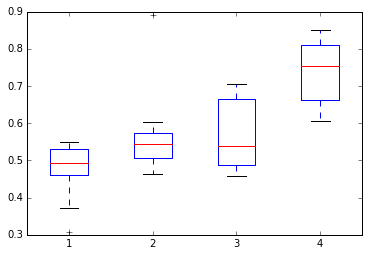

In [176]:
plt.boxplot(acc_all)
plt.show

In [171]:
np.median(SOacc)

0.4937750741170962

In [172]:
np.median(ISpec_acc)

0.54505497308197826

In [177]:
np.median(PSpec_acc)

0.53916072251825475

In [167]:
np.median(DSpec_acc)

0.75404926114731285

In [149]:
np.savetxt('results.csv', acc_all, delimiter=',') 